In [1]:
import sys
sys.path.append('/dev/git_repos/pyAPES_main')
import pandas as pd
import matplotlib.pyplot as plt

from pyAPES.utils.iotools import read_forcing
from pyAPES.canopy.forestfloor import ForestFloor
from pyAPES.parameters.mlm_parameters import gpara, cpara, spara # model configuration, canopy parameters, soil parameters

%matplotlib widget

import warnings
# Ignore FutureWarning messages globally
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

c:\dev/git_repos/pyAPES_main\pyAPES\bottomlayer\organiclayer.py:1125: SyntaxWarning: invalid escape sequence '\ '
  """


In [2]:
# Creating ForestFloor
forestfloor = ForestFloor(cpara['forestfloor'])

# Manipulating the params to correspond to those of Degerö
gpara['forc_filename'] = r'/dev/git_repos/pyAPES_main/forcing/Degero/Degero_forcing_2014-2016.dat'
gpara['start_time'] = '2014-09-01'
gpara['end_time'] = '2015-06-01'

In [3]:
# Reading the forcing file
forcing = read_forcing(
    forcing_file=gpara['forc_filename'],
    start_time=gpara['start_time'],
    end_time=gpara['end_time'],
    dt=gpara['dt']
)

forcing['Prec_liquid'] = forcing['Prec'].where(forcing['Tair'] > 1, 0)
forcing['Prec_ice'] = forcing['Prec'].where(forcing['Tair'] <= 1, 0)

In [4]:
# Looping over the forcing file, running forestfloor model for each timestep and saving the results
results_df = pd.DataFrame()

for index, row in forcing.iterrows():
    ff_forcing = {  # Reset the dictionary for each iteration
        'precipitation_rain': row['Prec_liquid'], # kg m-2 s-1
        'precipitation_snow': row['Prec_ice'], # kg m-2 s-1
        'wind_speed': row['U'], # m/s
        'par': row['diffPar'] + row['dirPar'],  # Total PAR [W m-2]
        'nir': row['diffNir'] + row['dirNir'],  # Total NIR [W m-2]
        'lw_dn': row['LWin'],  # Longwave downward radiation [W m-2]
        'h2o': row['H2O'] / 1000,  # H2O [mol mol-1]
        'co2': row['CO2'] * 1e6,  # Convert mol mol-1 to ppm
        'air_temperature': row['Tair'],  # Air temperature [degC]
        'air_pressure': row['P'],  # Air pressure [Pa]
        'soil_temperature': max(row['Tair']-2,0), # Soil temperature [degC]
        'soil_water_potential': -10,
        'soil_volumetric_water': 0.3,
        'soil_volumetric_air': 0.3,
        'soil_pond_storage': 0
    }
    ff_params = {
        'soil_thermal_conductivity': 0.8,
        'soil_hydraulic_conductivity': 1e-5,
        'soil_depth': 0.02,
        'reference_height': 2.0,
    }
    ff_controls = {
        'energy_balance': True,
        'logger_info': 'test',
    }
    # --- solve forestfloor
    ff_fluxes, ff_states, gt_results = forestfloor.run(
                dt=gpara['dt'],
                forcing=ff_forcing,
                parameters=ff_params,
                controls=ff_controls
                )
    
    forestfloor.update()
        
    # Combine results into a single dictionary with all values as floats
    combined_results = {
        'time': index,  # Use the time index from the forcing DataFrame
        **{f'gt_{key}': value[0] for key, value in gt_results.items()},  # Add gt_results
        **{f'ff_{key}': value for key, value in ff_states.items()},  # Add gt_results

    }

    # Append the combined results to the results DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([combined_results])], ignore_index=True)

results_df.set_index('time', inplace=True)

<Axes: xlabel='time'>

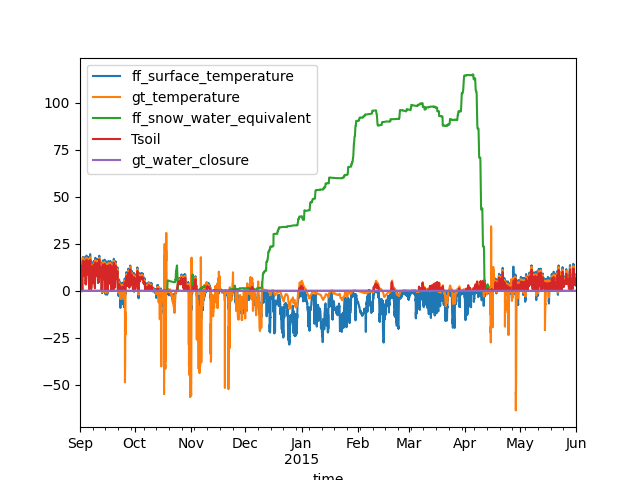

In [5]:
import numpy as np
results_df['Tsoil']=np.maximum(forcing['Tair']-2,0)
results_df[['ff_surface_temperature',
             'gt_temperature',
             'ff_snow_water_equivalent',
             'Tsoil',
             'gt_water_closure']].plot()


<Axes: xlabel='time'>

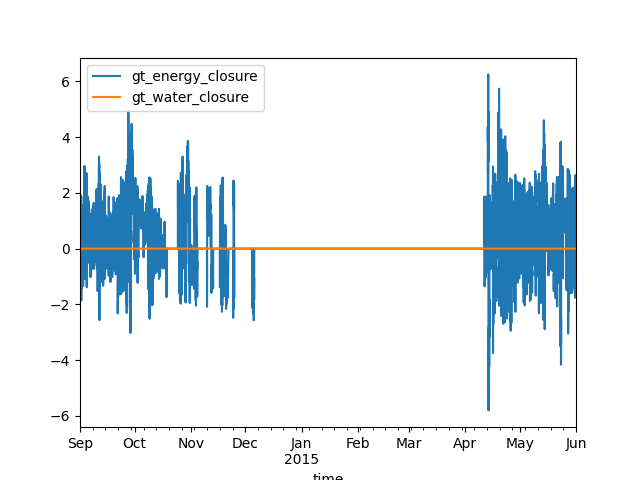

In [6]:
results_df[['gt_energy_closure',
             'gt_water_closure']].plot()